![OpenSARlab notebook banner](NotebookAddons/blackboard-banner.png)

# An Introduction to Simple SAR Change Detection Methods

### Franz J Meyer; University of Alaska Fairbanks 

<img src="NotebookAddons/UAFLogo_A_647.png" style="padding:5px;" width="170" align="right"/>

This notebook introduces you to a some popular change detection methods that can be applied on SAR time series data. SAR is an excellent tool for change detection. As SAR sensors are weather and illumination independent, and as SAR's carry their own illumination source (active sensor), differences between repeated images are a direct indication of changes on the surface. This fact is exploited by the change detection methods introduced below. 
    
The exercise is done in the framework of *Jupyter Notebooks*. The Jupyter Notebook environment is easy to launch in any web browser for interactive data exploration with provided or new training data. Notebooks are comprised of text written in a combination of executable python code and markdown formatting including latex style mathematical equations. Another advantage of Jupyter Notebooks is that they can easily be expanded, changed, and shared with new data sets or newly available time series steps. Therefore, they provide an excellent basis for collaborative and repeatable data analysis.

**This notebook covers the following data analysis concepts:**

- Time series metrics  95$^{th}$ and 5$^{th}$ percentile difference thresholding
- Time series coefficient of variation thresholding
- Log Ratio-based change detection from image pairs

<hr>
<font face="Calibri">

<font size="5"> <b> 0. Importing Relevant Python Packages </b> </font>

<font size="3">In this notebook we will use the following scientific libraries:
<ol type="1">
    <li> <b><a href="https://pandas.pydata.org/" target="_blank">Pandas</a></b> is a Python library that provides high-level data structures and a vast variety of tools for analysis. The great feature of this package is the ability to translate rather complex operations with data into one or two commands. Pandas contains many built-in methods for filtering and combining data, as well as the time-series functionality. </li>
    <li> <b><a href="https://www.gdal.org/" target="_blank">GDAL</a></b> is a software library for reading and writing raster and vector geospatial data formats. It includes a collection of programs tailored for geospatial data processing. Most modern GIS systems (such as ArcGIS or QGIS) use GDAL in the background.</li>
    <li> <b><a href="http://www.numpy.org/" target="_blank">NumPy</a></b> is one of the principal packages for scientific applications of Python. It is intended for processing large multidimensional arrays and matrices, and an extensive collection of high-level mathematical functions and implemented methods makes it possible to perform various operations with these objects. </li>
    <li> <b><a href="https://matplotlib.org/index.html" target="_blank">Matplotlib</a></b> is a low-level library for creating two-dimensional diagrams and graphs. With its help, you can build diverse charts, from histograms and scatterplots to non-Cartesian coordinates graphs. Moreover, many popular plotting libraries are designed to work in conjunction with matplotlib. </li>
    <li> The <b><a href="https://www.pydoc.io/pypi/asf-hyp3-1.1.1/index.html" target="_blank">asf-hyp3 API</a></b> provides useful functions and scripts for accessing and processing SAR data via the Alaska Satellite Facility's Hybrid Pluggable Processing Pipeline, or HyP3 (pronounced "hype"). </li>
<li><b><a href="https://www.scipy.org/about.html" target="_blank">SciPY</a></b> is a library that provides functions for numerical integration, interpolation, optimization, linear algebra and statistics. </li>

</font>

<font face="Calibri" size="3"> Our first step is to <b>import them:</b> </font>

In [ ]:
# %%capture
# from pathlib import Path
# from os import system
# import datetime # for date
# import re

# import pandas as pd # for DatetimeIndex
# from osgeo import gdal # for Info
# gdal.UseExceptions()

# %matplotlib inline
# import matplotlib.pyplot as plt
# from matplotlib import animation
# from matplotlib import rc
# import numpy as np

# from ipyfilechooser import FileChooser

# from IPython.display import HTML

# import opensarlab_lib as asfn
# asfn.jupytertheme_matplotlib_format()

## 1. Load Data Stack

In the Exercise4A-SARChangeDetectionMethods.ipynb notebook will used a dense 12-day repeat Sentinel-1 C-band SAR data stack. It contained imagery acquired during the year 2018 in Guatemala. The data was already prepared for you. Now, you will later learn how to download and pre-process Sentinel-1 images using the services of the [Alaska Satellite Facility](https://www.asf.alaska.edu/). 

**Begin by writing a function to retrieve the absolute paths to each of our tiffs:**

In [ ]:
# def get_tiff_paths(paths):
#     tiff_paths = !ls $paths | sort -t_ -k5,5
#     return tiff_paths

**Select the directory holding your tiffs**
- Click the `Select` button
- Navigate to your data directory
- Click the `Select` button
- Confirm that the desired path appears in green text
- Click the `Change` button to alter your selection

In [ ]:
# fc = FileChooser(Path.cwd())
# display(fc)

**Determine the path to the analysis directory containing the tiff directory:**

In [1]:
from pathlib import Path

change_detection_example_dir = Path.cwd() / "change_detection_example"

data_dir = change_detection_example_dir / "data"
data_dir.mkdir(parents=True, exist_ok=True)

plot_dir = change_detection_example_dir / "plots"
plot_dir.mkdir(exist_ok=True)

In [ ]:
import os
import asf_search as asf
# from getpass import getpass


wkt = "POLYGON((-57.759 -3.5099,-56.459 -3.5099,-56.459 -2.6352,-57.759 -2.6352,-57.759 -3.5099))"

opts=asf.ASFSearchOptions(**{
    "maxResults": 250,
    "intersectsWith": wkt,
    "processingLevel": [
        "GCOV"
    ],
    "dataset": [
        "NISAR"
    ],
    "productionConfiguration": [
        "PR"
    ],
    "host": "cmr.uat.earthdata.nasa.gov"
})

session = asf.ASFSession(cmr_host='cmr.uat.earthdata.nasa.gov')
# session.auth_with_token(getpass('UAT EDL token'))
session.auth_with_token(os.environ["UAT_TOKEN"])

response = asf.search(opts=opts)

hdf5_files = response.find_urls(extension='.h5', pattern=r'^(?!.*STATS).*DHDH.*', directAccess=False)
asf.download_urls(hdf5_files, data_dir, session=session, processes=4)

In [ ]:
# TODO: Delete when we have real NISAR data
# Duplicates the one sample GCOV file we have
import shutil

f = list(data_dir.glob('*.h5'))[0]
for i in range(7): 
    shutil.copy(f, f.parent / f"{f.stem}_{i}.h5")

In [2]:
gcov_files = sorted(list(data_dir.glob("*.h5")))
gcov_files

[PosixPath('/home/jovyan/opensarlab-notebooks/SAR_Training/English/Master/change_detection_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/SAR_Training/English/Master/change_detection_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_0.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/SAR_Training/English/Master/change_detection_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_1.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/SAR_Training/English/Master/change_detection_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_N_F_J_001_2.h5'),
 PosixPath('/home/jovyan/opensarlab-notebooks/SAR_Training/English/Master/change_detection_example/data/NISAR_L2_PR_GCOV_087_039_D_090_2005_DHDH_A_20251102T220639_20251102T220714_T00407_

In [3]:
import re
import h5py
import numpy as np
import xarray as xr
import dask.array as da
from dask import delayed

_date_regex = re.compile(r"_(\d{8}T\d{6})_")
def _get_ts(filename):
    match = _date_regex.search(filename)
    if match:
        ts_str = match.group(1)
        return np.datetime64(f"{ts_str[:4]}-{ts_str[4:6]}-{ts_str[6:8]}T{ts_str[9:11]}:{ts_str[11:13]}:{ts_str[13:15]}") 
    return np.datetime64("NaT")

def open_gcov(gcov_paths, vars_to_load=("HHHH", "HVHV", "mask", "numberOfLooks", "rtcGammaToSigmaFactor"), freqs=("A","B"), max_xy_chunk=2048):
    gcov_paths = sorted(gcov_paths)
    group = {f: f"/science/LSAR/GCOV/grids/frequency{f}" for f in freqs}
    with h5py.File(gcov_paths[0], "r") as f0:
        g = f0[group[freqs[0]]]
        x, y = g["xCoordinates"][...], g["yCoordinates"][...]
        proj = g["projection"][()]
    ny, nx = len(y), len(x)
    time = np.array([_get_ts(p.name) for p in gcov_paths])
    chunks = (1, 1, min(ny, max_xy_chunk), min(nx, max_xy_chunk))  # (time, frequency, y, x)

    data_vars = {}
    for v in vars_to_load:
        per_freq = []
        for freq in freqs:
            with h5py.File(gcov_paths[0], "r") as f0:
                dt = f0[f"{group[freq]}/{v}"].dtype
            planes = [da.from_delayed(delayed(lambda p, d: h5py.File(p,"r")[d][...])(p, f"{group[freq]}/{v}"),
                                      shape=(ny, nx), dtype=dt)[None, None, ...]
                      for p in gcov_paths]
            per_freq.append(da.concatenate(planes, axis=0))
        stacked = da.concatenate(per_freq, axis=1).rechunk(chunks)
        data_vars[v] = (("time","frequency","y","x"), stacked)

    return xr.Dataset(
        data_vars=data_vars,
        coords={"time": time, "frequency": np.array(list(freqs)), "y": y, "x": x},
        attrs={"source": "NISAR L2 GCOV", "projection": proj},
    )

In [4]:
ds = open_gcov(gcov_files)
ds

<xarray.Dataset> Size: 72GB
Dimensions:                (time: 8, frequency: 2, y: 15984, x: 16668)
Coordinates:
  * time                   (time) datetime64[s] 64B 2025-11-02T22:06:39 ... 2...
  * frequency              (frequency) <U1 8B 'A' 'B'
  * y                      (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06
  * x                      (x) float64 133kB 3.312e+05 3.312e+05 ... 6.646e+05
Data variables:
    HHHH                   (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV                   (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    mask                   (time, frequency, y, x) uint8 4GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    numberOfLooks          (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    rtcGammaToSigmaFactor  (time, frequency, y, x) float32 17GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

In [5]:
# TODO: remove this when there is real NISAR data
# Fakes a time series by updating dates and backscatter

import pandas as pd

fake_times = pd.date_range(
    start="2025-11-02T22:06:39",
    periods=ds.sizes["time"],
    freq="D"
)

ds = ds.assign_coords(time=fake_times)

# adjust each duplicated time step's backscatter values for better test visualization
factors = 1 + 0.3 * np.sin(np.linspace(0, 2*np.pi, ds.sizes["time"]))
scaled = ds * xr.DataArray(factors, dims=["time"])
scaled = scaled.assign_attrs(ds.attrs)
ds = scaled
ds

<xarray.Dataset> Size: 171GB
Dimensions:                (frequency: 2, y: 15984, x: 16668, time: 8)
Coordinates:
  * frequency              (frequency) <U1 8B 'A' 'B'
  * y                      (y) float64 128kB 9.819e+06 9.819e+06 ... 9.499e+06
  * x                      (x) float64 133kB 3.312e+05 3.312e+05 ... 6.646e+05
  * time                   (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... ...
Data variables:
    HHHH                   (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    HVHV                   (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    mask                   (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    numberOfLooks          (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
    rtcGammaToSigmaFactor  (time, frequency, y, x) float64 34GB dask.array<chunksize=(1, 1, 2048, 2048), meta=np.ndarray>
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

**Determine the path to the analysis directory containing the tiff directory:**

In [ ]:
# polarization = asfn.select_parameter(['VV', 'VH'], 'polarization:')
# polarization

In [6]:
%%time
polarization = "HVHV"
frequency = "A"

da = ds[polarization].sel(frequency=frequency,
                          x=slice(400000.0, 500000.0),
                          y=slice(9700000.0, 9600000.0))
da = da.assign_attrs({**ds.attrs, **da.attrs})
# da.load()
da

CPU times: user 4.08 ms, sys: 0 ns, total: 4.08 ms
Wall time: 3.13 ms


<xarray.DataArray 'HVHV' (time: 8, y: 5000, x: 5000)> Size: 2GB
dask.array<getitem, shape=(8, 5000, 5000), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    frequency  <U1 4B 'A'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
  * time       (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... 2025-11-09T2...
Attributes:
    source:      NISAR L2 GCOV
    projection:  32721

In [ ]:
# pol = polarization.value
# print(f'polarization: {pol}')

**Create a wildcard path to the tiffs:**

In [ ]:
# if pol == 'VV':
#     wildcard_path = f"{tiff_dir}/*VV*.tif*"
# else:
#     wildcard_path = f"{tiff_dir}/*VH*.tif*"
# print(f'wildcard_path: \n{wildcard_path}')

**Write a function to extract the tiff dates from a wildcard path.**

In [ ]:
# def get_date(pth):
#     date_regex = r'(?<=_)\d{8}(?=T\d{6})'
#     try:
#         return re.search(date_regex, str(pth)).group(0)
#     except AttributeError:
#         raise Exception(f"Date string not found in {pth}")

**Call get_dates() to collect the product acquisition dates:**

In [ ]:
# file_ext = None
# if pol == 'VV':
#     file_ext = f'*VV*.tif*'
# else:
#     file_ext = f'*VH*.tif*'

# dates = sorted([get_date(d) for d in tiff_dir.rglob(file_ext)])
# print(f'dates: \n{dates}')

## 2. Create the VRTs

**Create the virtual raster table for the GeoTiffs:**

In [ ]:
# raster_path = f"{analysis_dir}/raster_stack_{pol}.vrt"
# !gdalbuildvrt -separate $raster_path $wildcard_path

## 3. Define Some Python Helper Functions for this Notebook

We are defining two helper functions for this notebook:

- **CreateGeoTiff()** to write out images
- **timeseries_metrics()** to compute various metrics from a time series data stack

In [ ]:
def create_geotiff(name, array, data_type, ndv, bandnames=None, 
                   ref_image=None, geo_t=None, projection=None):
    # If it's a 2D image we fake a third dimension:
    if len(array.shape) == 2:
        array = np.array([array])
    if ref_image == None and (geo_t == None or projection == None):
        raise RuntimeWarning('ref_image or settings required.')
    if bandnames != None:
        if len(bandnames) != array.shape[0]:
            raise RuntimeError(f'Need {Array.shape[0]} bandnames. {len(bandnames)} given')
    else:
        bandnames = [f'Band {i+1}' for i in range(array.shape[0])]
    if ref_image != None:
        refimg = gdal.Open(ref_image)
        geo_t = refimg.GetGeoTransform()
        Projection = refimg.GetProjection()
    driver = gdal.GetDriverByName('GTIFF')
    array[np.isnan(array)] = ndv
    dataset = driver.Create(name, array.shape[2], array.shape[1], 
                            array.shape[0], data_type)
    dataset.SetGeoTransform(geo_t)
    dataset.SetProjection(projection)
    for i, image in enumerate(array, 1):
        dataset.GetRasterBand(i).WriteArray(image)
        dataset.GetRasterBand(i).SetNoDataValue(ndv)
        dataset.SetDescription(bandnames[i-1])
    dataset.FlushCache()
    return name

In [ ]:
da

In [ ]:
# def timeseries_metrics(raster, ndv=np.nan):     
#     # Make us of numpy nan functions
#     # Check if type is a float array
#     if not raster.dtype.name.find('float')>-1:
#         raster = raster.astype(np.float64)
#     # Set ndv to nan
#     if not np.isnan(ndv):
#         raster[np.equal(raster,ndv)] = np.nan
#     # Build dictionary of the metrics
#     tsmetrics={}
#     rperc = np.nanpercentile(raster,[5,50,95], axis=0)
#     tsmetrics['mean'] = np.nanmean(raster, axis=0)
#     tsmetrics['max'] = np.nanmax(raster, axis=0)
#     tsmetrics['min'] = np.nanmin(raster, axis=0)
#     tsmetrics['range'] = tsmetrics['max'] - tsmetrics['min']
#     tsmetrics['median'] = rperc[1]
#     tsmetrics['p5'] = rperc[0]
#     tsmetrics['p95'] = rperc[2]
#     tsmetrics['prange'] = rperc[2]-rperc[0]
    # tsmetrics['var'] = np.nanvar(raster, axis=0)
    # tsmetrics['std'] = np.sqrt(tsmetrics['var'])
    # tsmetrics['CV'] = np.abs(tsmetrics['var'] / tsmetrics['mean'])
#     return tsmetrics

In [7]:
def timeseries_metrics(da):     
    q = da.quantile([0.05, 0.5, 0.95], dim="time")
    p05 = q.sel(quantile=0.05, drop=True)
    p50 = q.sel(quantile=0.50, drop=True)
    p95 = q.sel(quantile=0.95, drop=True)
    prange = p95 - p05
    
    max = da.max(dim="time")
    min = da.min(dim="time")
    range = max - min

    mean = da.mean(dim="time")
    var = da.var(dim="time")
    std = da.std(dim="time")
    cv = std / xr.where(mean != 0, mean, np.nan)
    
    return xr.Dataset(
        dict(
            min=min, max=max, range=range,
            mean=mean, var=var, std=std, CV=cv,
            p05=p05, p50=p50, p95=p95,
            prange=p95 - p05
        )
    )

## 4. Create a Pandas Time Index and Display the VRT Band Dates

**Create an index of timedelta64 data with Pandas:**

In [ ]:
# tindex = pd.DatetimeIndex(dates)

**Print the bands and dates for all images in the virtual raster table (VRT):**

In [ ]:
# j = 1
# print(f"Bands and dates for {raster_path}")
# for i in tindex:
#     print("{:4d} {}".format(j, i.date()), end=' ')
#     j += 1
#     if j%5 == 1:
#         print()

---
## 4. Create a Time Series Animation to get an Idea of the Dynamics at the Site

### 4.1 Load Time Series Stack

Now we are ready to create a time series animation from the calibrated SAR data.

**First, create a raster from band 0 and a raster stack from all the images:**

In [ ]:
# img = gdal.Open(raster_path)
# band = img.GetRasterBand(1)
# raster0 = band.ReadAsArray()
# band_number = 0 # Needed for updates
# rasterstack = img.ReadAsArray()

**Print the bands, pixels, and lines:**

In [ ]:
# print(f"Number of  bands: {img.RasterCount}")
# print(f"Number of pixels: {img.RasterXSize}")
# print(f"Number of  lines: {img.RasterYSize}")

## 4.2 Data Conversion between dB and Power Scales

The data at hand are radiometrically terrain corrected images, which are often expressed as terrain flattened $\gamma^0$ backscattering coefficients. For forest and land cover monitoring applications $\gamma^0$ is the preferred metric.

To use a logarithmic scale instead of the natural power scale, **you can set the following variable to True:**

In [ ]:
# todB = True

# labeldB = 'dB' if todB else 'linear'

# def convert(raster, todB=todB):
#     if todB:
#         return 10 * np.ma.log10(raster)
#     else:
#         return raster

In [8]:
%%time
da_db = 10*np.log10(da)
da_db

CPU times: user 1.85 ms, sys: 0 ns, total: 1.85 ms
Wall time: 1.85 ms


<xarray.DataArray 'HVHV' (time: 8, y: 5000, x: 5000)> Size: 2GB
dask.array<mul, shape=(8, 5000, 5000), dtype=float64, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    frequency  <U1 4B 'A'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
  * time       (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... 2025-11-09T2...

## 4.3 Create Time Series Animation

**Create and move into a directory in which to store our plots and animations:**

In [ ]:
# product_path = analysis_dir/f'plots_and_animations'

# if not product_path.exists():
#     print(f'{product_path} created')
#     product_path.mkdir()

Now we can **create the information needed to animate our data:**

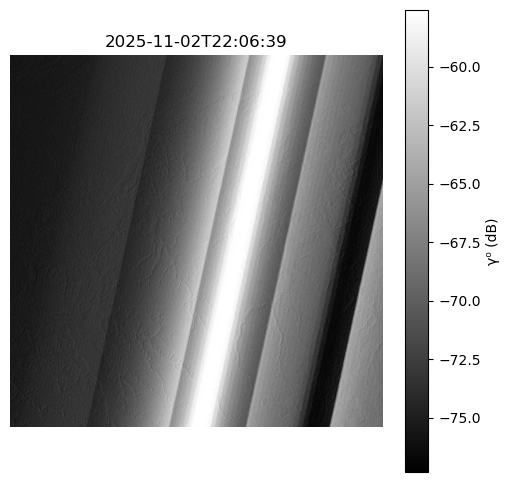

CPU times: user 25.2 s, sys: 3.47 s, total: 28.7 s
Wall time: 23.2 s


In [9]:
%%time
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import FFMpegWriter, PillowWriter

vmin, vmax = (da_db.quantile([0.05, 0.95], skipna=True).values.astype(float))

fig, ax = plt.subplots(figsize=(6, 6))
frame_0 = da_db.isel(time=0).values
im = ax.imshow(frame_0, vmin=vmin, vmax=vmax, origin="upper", cmap="grey")
cb = fig.colorbar(im, ax=ax, label="γ⁰ (dB)")
ax.set_title(np.datetime_as_string(da_db.time.values[0], unit='s'))
ax.set_axis_off()

def animate(i):
    frame = da_db.isel(time=i).values
    im.set_data(frame)
    ax.set_title(np.datetime_as_string(da_db.time.values[i], unit='s'))
    return (im,)

ani = FuncAnimation(fig, animate, frames=da_db.sizes["time"], interval=300, blit=False)

plt.show()

In [10]:
from IPython.display import HTML

HTML(ani.to_jshtml())

In [ ]:
# %%capture 
# fig = plt.figure(figsize=(10, 5))
# ax = fig.subplots()
# ax.axis('off')

# copyRaster = np.copy(convert(rasterstack))
# vmin = np.nanpercentile(copyRaster, 1)
# vmax = np.nanpercentile(copyRaster, 99)

# im = ax.imshow(convert(raster0), cmap='inferno', vmin=vmin, vmax=vmax)
# cbar = fig.colorbar(im)
# cbar.set_label(labeldB)
# ax.set_title("{}".format(tindex[0].date()))
# plt.rcParams.update({'font.size': 14})

# def animate(i):
#     ax.set_title("{}".format(tindex[i].date()))
#     im.set_data(convert(rasterstack[i]))

# # Interval is given in milliseconds
# ani = animation.FuncAnimation(fig, animate, frames=rasterstack.shape[0], interval=300)

**Configure matplotlib's RC settings for the animation:**

In [ ]:
# rc('animation', embed_limit=40971520.0)  # We need to increase the limit maybe to show the entire animation

**Create a javascript animation of the time-series running inline in the notebook:**

In [ ]:
# HTML(ani.to_jshtml())

**Delete the dummy png that was saved to the current working directory while generating the javascript animation in the last code cell.**

In [ ]:
# try:
#     Path('/home/jovyan/notebooks/SAR_Training/English/Master/None0000000.png').unlink()
# except FileNotFoundError:
#     pass

**Save the animation (animation.gif):**

In [ ]:
ani.save(plot_dir/f'animation.gif', writer='pillow', fps=2)

---
## 5. Computation and Visualization of Time Series Metrics

Once a time-series was constructed, we can compute **a set of metrics** for each pixel in the stack:

- Mean 
- Median
- Maximum
- Minimum
- Range (Maximum - Minimum)
- 5th Percentile
- 95th Percentile
- PRange (95th - 5th Percentile)
- Variance
- Coefficient of Variation (Variance/Mean)

---
First, we **mask out pixels** that are zero (e.g. beyond the edge of the swath). Then we **calculate the time series metrics:**

In [ ]:
# mask = (rasterstack == 0)
# raster = np.ma.array(convert(rasterstack), mask=mask, dtype=np.float64)

In [11]:
%%time
# calc metric in power
metrics = timeseries_metrics(da)
metrics.load()
metrics

CPU times: user 1min 24s, sys: 18.6 s, total: 1min 42s
Wall time: 56.2 s


<xarray.Dataset> Size: 2GB
Dimensions:    (y: 5000, x: 5000)
Coordinates:
    frequency  <U1 4B 'A'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05
Data variables:
    min        (y, x) float64 200MB 2.867e-08 2.171e-08 ... 7.217e-08 9.814e-08
    max        (y, x) float64 200MB 5.238e-08 3.967e-08 ... 1.318e-07 1.793e-07
    range      (y, x) float64 200MB 2.371e-08 1.795e-08 ... 5.967e-08 8.114e-08
    mean       (y, x) float64 200MB 4.053e-08 3.069e-08 ... 1.02e-07 1.387e-07
    var        (y, x) float64 200MB 6.467e-17 3.709e-17 ... 4.097e-16 7.575e-16
    std        (y, x) float64 200MB 8.041e-09 6.09e-09 ... 2.024e-08 2.752e-08
    CV         (y, x) float64 200MB 0.1984 0.1984 0.1984 ... 0.1984 0.1984
    p05        (y, x) float64 200MB 2.949e-08 2.234e-08 ... 7.424e-08 1.009e-07
    p50        (y, x) float64 200MB 4.053e-08 3.069e-08 ... 1.02e-07 1.387e-07
    p95        (y, x) float64 200MB 5.156e-08 3.905e-08 ... 1.298e-07 1.765e-07
    prange     (y, x) float64 200MB 2.206e-08 1.671e-08 ... 5.553e-08 7.551e-08

In [ ]:
# metrics.keys()

Let's look at the histograms for the time series variance and coeficient of variation to aid displaying those images:

In [ ]:
# fig, ax = plt.subplots(1,2,figsize=(16,4))
# ax[0].hist(metrics['var'].flatten(), bins=100, range=np.nanpercentile(metrics['var'], [1,99]))
# ax[1].hist(metrics['CV'].flatten(), bins=100, range=np.nanpercentile(metrics['CV'], [1,99]))
# _ = ax[0].set_title('Variance')
# _ = ax[1].set_title('Coefficient of Variation')

In [ ]:
np.min(cv)

In [ ]:
np.max(cv)

In [ ]:
len(cv)

ValueError: Too many bins for data range. Cannot create 100 finite-sized bins.

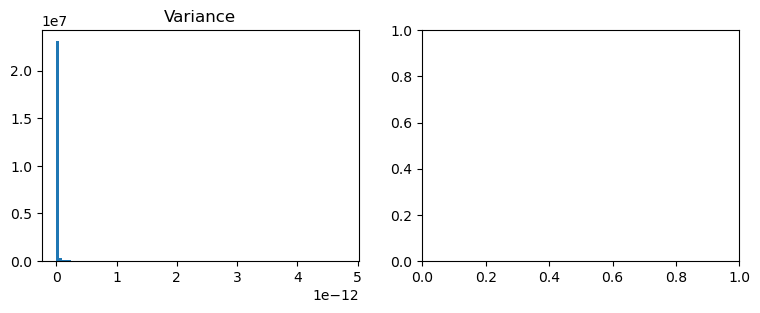

In [12]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1,2,figsize=(9, 3))

var = metrics["var"].values.ravel()
ax[0].hist(var, bins=100, range=np.nanpercentile(var, [1,99]))
ax[0].set_title('Variance')

cv = metrics["CV"].values.ravel()
ax[1].hist(cv, bins=100, range=np.nanpercentile(cv, [1,99]))
ax[1].set_title('Coefficient of Variation')

plt.show()

In [ ]:
# # List the metrics keys you want to plot
# metric_keys=['mean', 'median', 'max', 'min', 
#              'p95', 'p5', 'prange', 'var', 'std', 'CV']
# fig= plt.figure(figsize=(16,40))
# idx=1
# for i in metric_keys:
#     ax = fig.add_subplot(5,2,idx)
#     vmin, vmax = np.nanpercentile(metrics[i], [1, 99])
#     ax.imshow(metrics[i],vmin=vmin,vmax=vmax,cmap='inferno')
#     ax.set_title(i.upper())
#     ax.axis('off')
#     idx+=1

In [ ]:
metrics

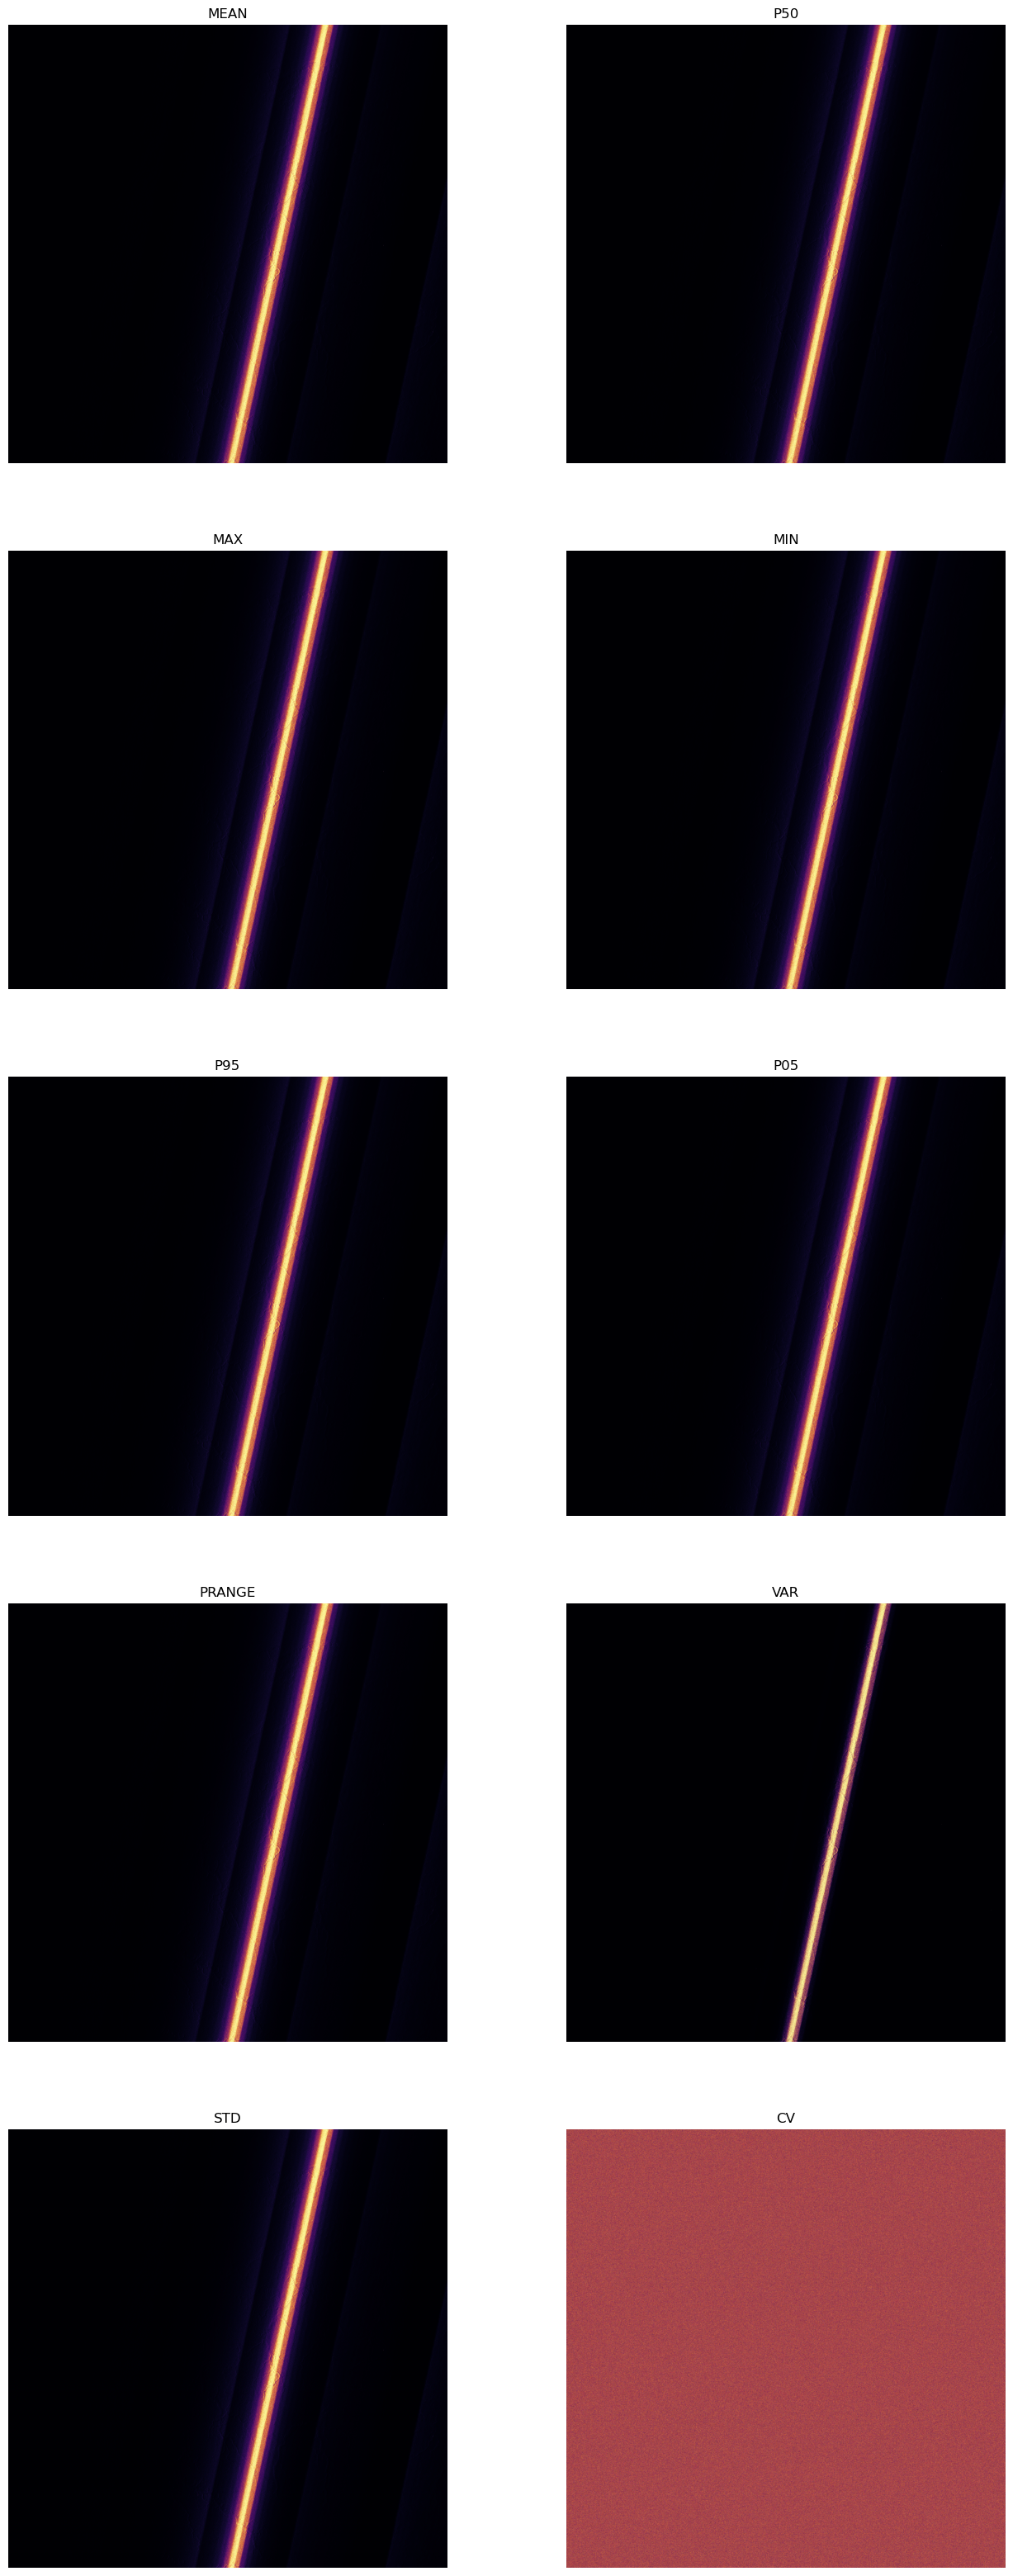

In [13]:
# List the metrics keys you want to plot
metric_keys=['mean', 'p50', 'max', 'min', 
             'p95', 'p05', 'prange', 'var', 'std', 'CV']
fig= plt.figure(figsize=(16,40))
idx=1
for i in metric_keys:
    ax = fig.add_subplot(5,2,idx)
    vmin, vmax = np.nanpercentile(metrics[i], [1, 99])
    ax.imshow(metrics[i],vmin=vmin,vmax=vmax,cmap='inferno')
    ax.set_title(i.upper())
    ax.axis('off')
    idx+=1

You might have noticed white patches in the images above. These do not contain any data. The reason is that they are in the radar shadow of terrain that is closer to the satellite.

---

## 6. Some Popular SAR Change Detection Methods

This section will introduce you to the following popular and simple change detection methods:

- Time series metrics  95$^{th}$ and 5$^{th}$ percentile difference and standard deviation thresholding
- Time series coefficient of variation thresholding

---
### 6.1 Change Detection with the Percentile Difference and the Variance Threshold Method

In this method we find thresholds on the **95$^{th}$ and 5$^{th}$ percentile difference** or the **temporal pixel-by-pixel gray value cariance**. Let's start with the 95$^{th}$ and 5$^{th}$ percentile difference. The advantage to look at percentiles verus maximum minus minimum is that it is more robust to outliers.

First, let us define a **function for plotting histograms:**

In [24]:
def plot_histogram_cdf(metric='std'):
    plt.rcParams.update({'font.size': 12})
    fig = plt.figure(figsize=(14, 4)) # Initialize figure with a size
    ax1 = fig.add_subplot(121)  # 121 determines: 2 rows, 2 plots, first plot
    ax2 = fig.add_subplot(122)

    h = ax1.hist(
        metrics[metric].values.ravel(), range=np.nanpercentile(metrics[metric], [1, 99]))
    ax1.xaxis.set_label_text(f'{metric}')
    ax1.set_title('Histogram')

    n, bins, patches = ax2.hist(
        metrics[metric].values.ravel(), range=np.nanpercentile(metrics[metric], [1, 99]),
        cumulative='True', density='True', histtype='step', label='Empirical')

    ax2.xaxis.set_label_text(f'{metric}')
    ax2.set_title('CDF')

    outind = np.where(n > 0.95)   
    threshind = np.min(outind)
    thresh = bins[threshind]
    ax1.axvline(thresh,color='red')
    _ = ax2.axvline(thresh,color='red')
    plt.savefig(plot_dir/f'{metric}_histogram.png',
                dpi=200, transparent='true')

**Now let's look at the 95th - 5th percentile range**

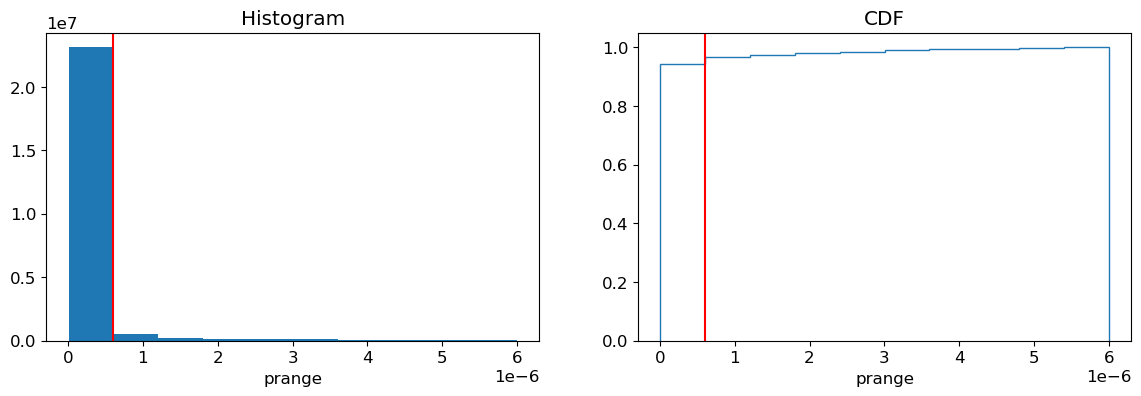

In [25]:
plot_histogram_cdf(metric='prange')

Let's visualize the 5% of all pixels with the largest (95th - 5th percentile) difference in the time series. We will refer to the pixels (x,y) that exceed this threshold $t$ as likely **change pixels (cp):**

${cp}_{x,y} = P_{x,y}^{95th} - P_{x,y}^{5th} > t$ 

If we define $t$ to correspond to the 5% of pixels with highest (95th - 5th percentile) difference, the image looks like:

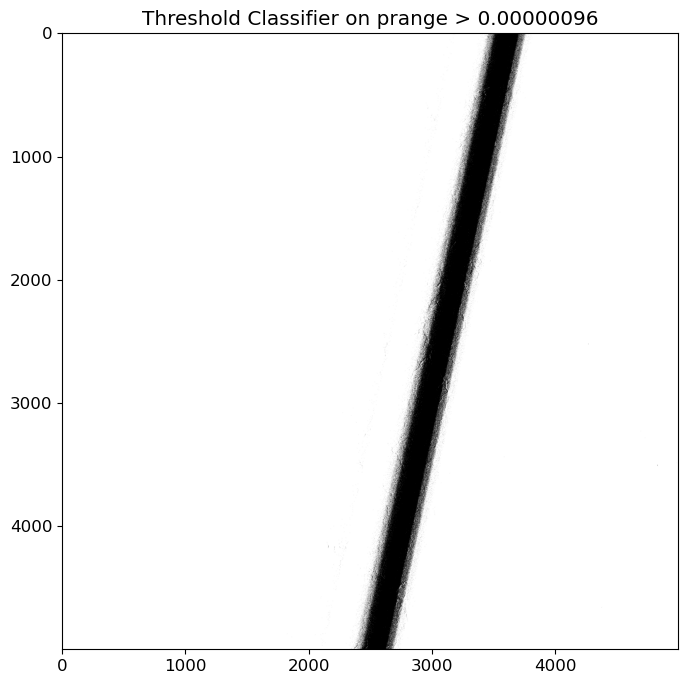

In [28]:
def plot_threshold_classifier(metric='prange', percentage_cutoff=5):
    plt.figure(figsize=(8,8))
    thresh = np.nanpercentile(metrics[metric], 100 - percentage_cutoff)
    mask = metrics[metric] < thresh # For display we prepare the inverse mask
    plt.imshow(mask, cmap='gray')
    _=plt.title(f'Threshold Classifier on {metric} > %1.8f' % thresh)
    plt.savefig(plot_dir/f'changes_{metric}.png',
            dpi=200, transparent='true')
    return np.logical_not(mask)

metric = 'prange'
masks = {metric: plot_threshold_classifier(metric=metric)}

Instead of applying a threshold on the 95th - 5th percentile difference data, we can also attempt to threshold other metrics. The **standard deviation** (or variance) variable seems a useful indicator for change as it identifies pixels for which radar brightness has changed strongly within the time series. Hence, in the following we use this metric for change identification according to:

${cp}_{x,y} = \sigma > t$ 

with $t=CDF_{\sigma} > 0.95$ (5% pixels with highest standard deviation):

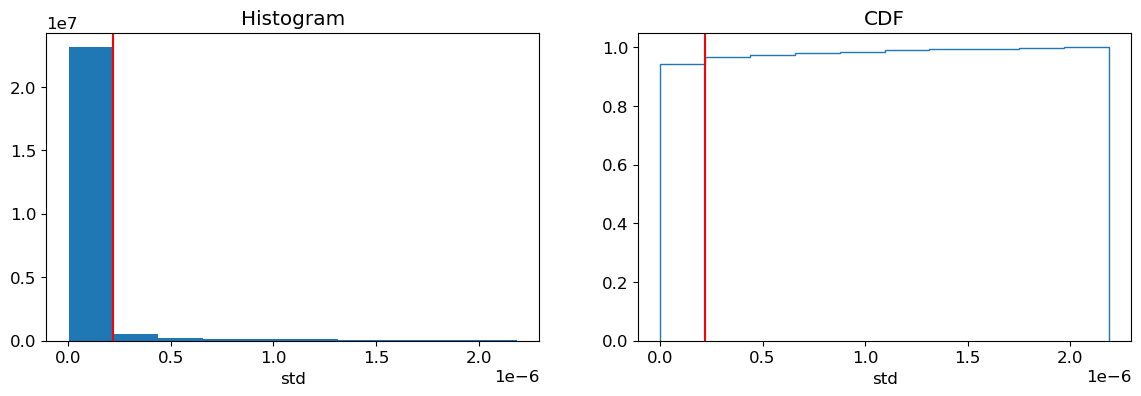

In [29]:
plot_histogram_cdf(metric='std')

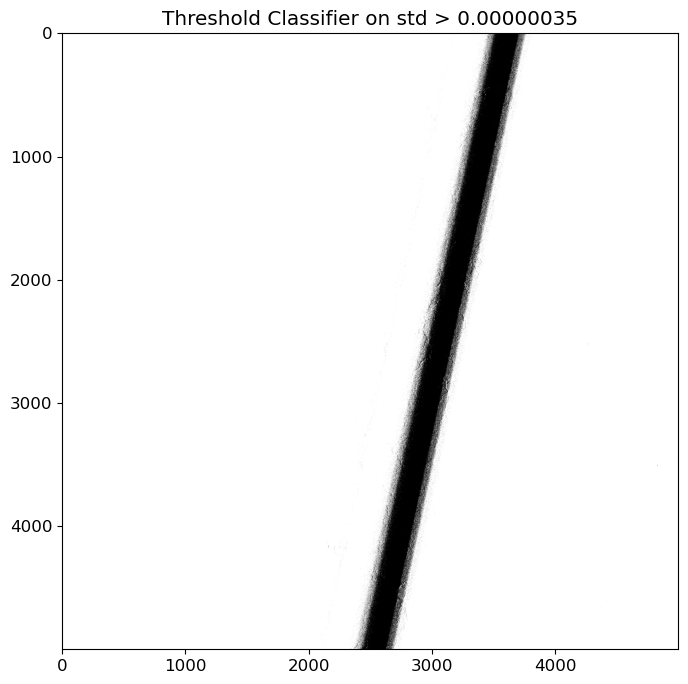

In [30]:
metric = 'std'
masks[metric] = plot_threshold_classifier(metric=metric)

### 6.2 Change Detection with the Coefficient of Variation Method

We can also set a threshold $t$ for the **coefficient of variation image**
to classify change in the time series:
    
${CV}_{x,y} = \frac{\sigma_{x,y}}{\overline{X}_{x,y}} > t$ 

Let's look at the histogram and the Cumulative Distribution Function (CDF) of the coefficient of variation: 

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

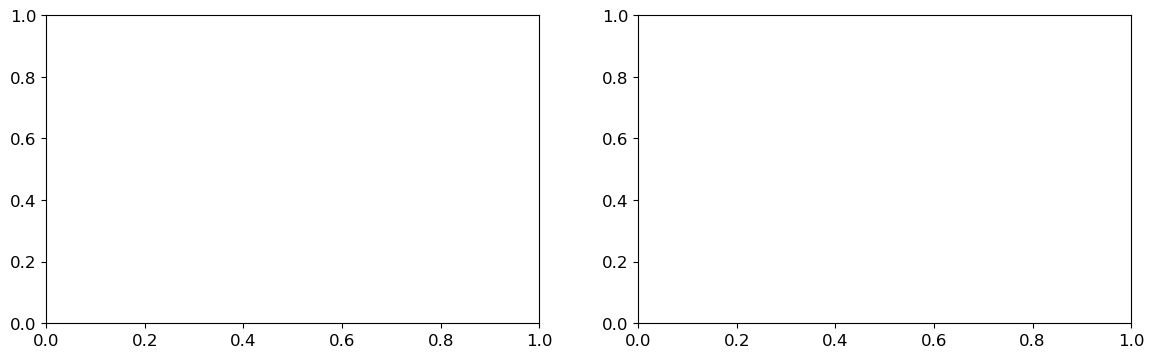

In [31]:
plot_histogram_cdf(metric='CV')

With a threshold of $t=CDF_{CV} > 0.95$ (5% pixels with highest variance) the change pixels would look like the following image:

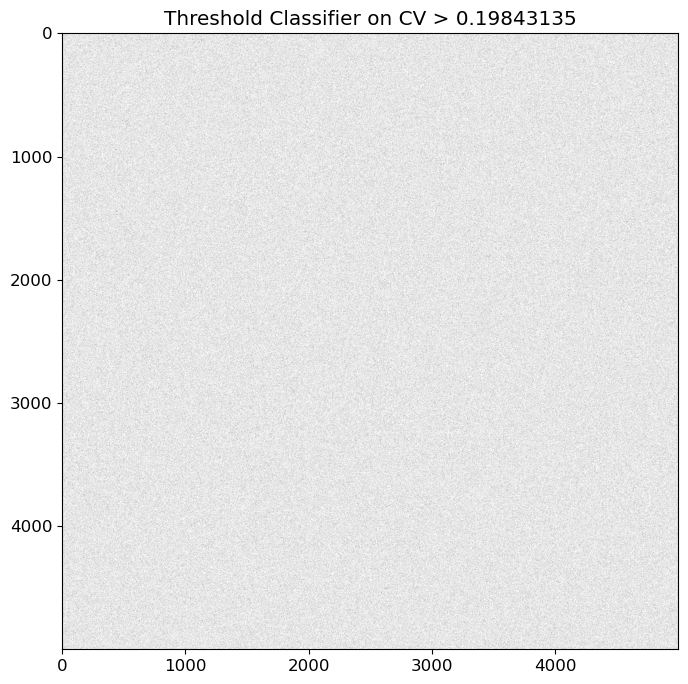

In [32]:
metric = 'CV'
masks[metric] = plot_threshold_classifier(metric=metric)

### 6.3 Pair-wise change detection

To analyze temporal changes between two images, it is useful to compute metrics that are sensitive to discrepancies between the two images. In radar remote sensing, the standard way is to look at ratios (in the linearly scaled power domain) or, equivalently, at differences in the logarithmic dB domain. 

In [ ]:
# dates = ('2018-05-27', '2018-06-08') # around first eruption

# # convert to datetime objects
# dates_ = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# # get the indices in one line
# dates_ind = [np.argmin(np.abs(date - tindex)) for date in dates_]
# print(f'Comparing image {dates_ind[0]} from {tindex[dates_ind[0]].date()} with {dates_ind[1]} from {tindex[dates_ind[1]].date()}')

In [ ]:
dates = ('2025-11-03', '2025-11-07') # around first eruption

# convert to datetime objects
dates_ = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]

# get the indices in one line
dates_ind = [np.argmin(np.abs(date - tindex)) for date in dates_]
print(f'Comparing image {dates_ind[0]} from {tindex[dates_ind[0]].date()} with {dates_ind[1]} from {tindex[dates_ind[1]].date()}')

In [34]:
da.time

<xarray.DataArray 'time' (time: 8)> Size: 64B
array(['2025-11-02T22:06:39.000000000', '2025-11-03T22:06:39.000000000',
       '2025-11-04T22:06:39.000000000', '2025-11-05T22:06:39.000000000',
       '2025-11-06T22:06:39.000000000', '2025-11-07T22:06:39.000000000',
       '2025-11-08T22:06:39.000000000', '2025-11-09T22:06:39.000000000'],
      dtype='datetime64[ns]')
Coordinates:
    frequency  <U1 4B 'A'
  * time       (time) datetime64[ns] 64B 2025-11-02T22:06:39 ... 2025-11-09T2...

**Compute the log ratio in dB**, corresponding to the difference in dB

In [ ]:
# ratiodB = 10 * np.ma.log10(np.ma.divide(rasterstack[dates_ind[1], ...], rasterstack[dates_ind[0], ...]))

In [83]:
date_0 = da.sel(time="2025-11-03").squeeze("time", drop=True)
date_1 = da.sel(time="2025-11-07").squeeze("time", drop=True)

ratiodB = 10 * np.log10(date_1 / date_0)
ratiodB

<xarray.DataArray 'HVHV' (y: 5000, x: 5000)> Size: 200MB
dask.array<mul, shape=(5000, 5000), dtype=float64, chunksize=(2048, 2048), chunktype=numpy.ndarray>
Coordinates:
    frequency  <U1 4B 'A'
  * y          (y) float64 40kB 9.7e+06 9.7e+06 9.7e+06 ... 9.6e+06 9.6e+06
  * x          (x) float64 40kB 4e+05 4e+05 4e+05 ... 5e+05 5e+05 5e+05

**Let us manually choose a threshold this time**

thresh is the threshold, e.g. -2 dB

thresh_type determines whether we mask everything below that (lower) or above (upper)

In [ ]:
# thresh = -2
# thresh_type = 'lower' #'lower': mask everything below thresh, 'upper': mask everything above

# copy_absRatiod = np.copy(np.abs(ratiodB))
# # dynamic_range = np.nanpercentile(np.abs(ratiodB), 99)
# dynamic_range = np.nanpercentile(copy_absRatiod, 99)
# fig, axs = plt.subplots(ncols=3, nrows=1)
# fig.set_size_inches(20, 4)
# plt.subplots_adjust(hspace=0.4, right=0.85)

# # h = axs[0].hist(
# #         ratiodB.flatten(), bins=200, range=np.nanpercentile(ratiodB, [0.1, 99.9]))

# h = axs[0].hist(
#         ratiodB.flatten(), bins=200, range=np.nanpercentile(np.copy(ratiodB), [0.1, 99.9]))

# axs[0].xaxis.set_label_text(f'difference [dB]')
# axs[0].set_title('Histogram')
# im0 = axs[1].imshow(ratiodB, cmap='RdBu', vmin=-dynamic_range, vmax=dynamic_range)
# cbar = fig.colorbar(im0, orientation='vertical', ax=axs.ravel().tolist(), shrink=0.7)
# cbar.set_label('[dB]')
# axs[1].set_title('Image')
# mask = (ratiodB > thresh if thresh_type == 'lower' else ratiodB < thresh).astype(np.int8)
# axs[2].imshow(mask, cmap='gray')
# axs[2].set_title('Mask')
# fig.suptitle(f'{tindex[dates_ind[0]].date()} {tindex[dates_ind[0]].date()}')
# logratiolabel = f'logratio_{tindex[dates_ind[0]].date()}_{tindex[dates_ind[0]].date()}'
# plt.savefig(product_path/f'{logratiolabel}.png',
#             dpi=200, transparent='true')
# masks[logratiolabel] = np.logical_not(mask)

In [92]:
# np.nanpercentile(np.copy(ratiodB), [0.1, 99.9])
low, high = (ratiodB.quantile([0.01, 0.99]))
low.compute().item()

-2.417687692831179

In [93]:
high.compute().item()

-2.417687692831178

In [99]:
thresh = -2
a = ratiodB < thresh
a.max().compute().item()

True

ValueError: Too many bins for data range. Cannot create 10 finite-sized bins.

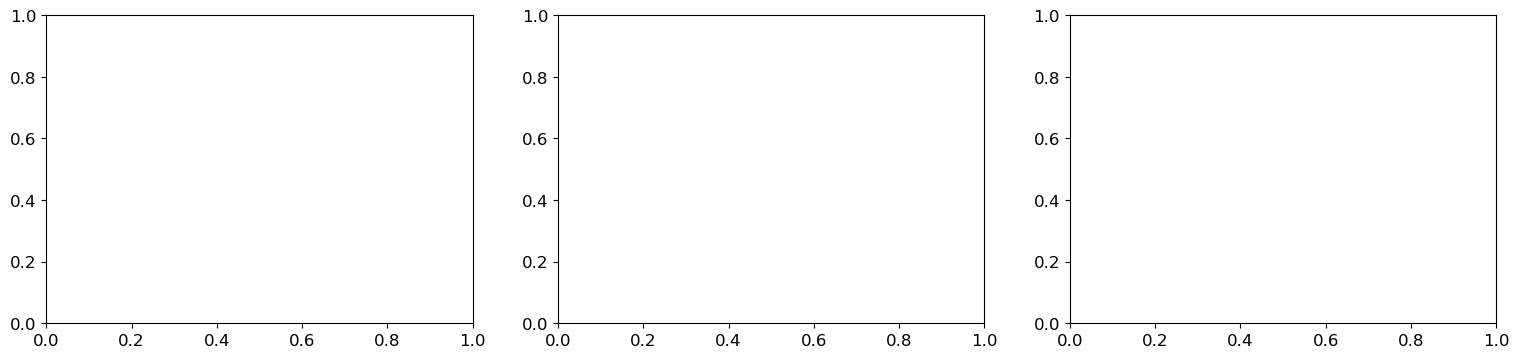

In [101]:
thresh = -2
thresh_type = 'lower' #'lower': mask everything below thresh, 'upper': mask everything above

abs_ratiodB = np.abs(ratiodB)
dynamic_range = abs_ratiodB.quantile(0.99, skipna=True).compute().item()


fig, axs = plt.subplots(ncols=3, nrows=1)
fig.set_size_inches(20, 4)
plt.subplots_adjust(hspace=0.4, right=0.85)

# h = axs[0].hist(
#         ratiodB.flatten(), bins=200, range=np.nanpercentile(ratiodB, [0.1, 99.9]))

axs[0].hist(
        ratiodB.values.ravel(), bins=10, range=np.nanpercentile(ratiodB, [0.1, 99.9]))

axs[0].xaxis.set_label_text(f'difference [dB]')
axs[0].set_title('Histogram')

im0 = axs[1].imshow(ratiodB, cmap='RdBu', vmin=-dynamic_range, vmax=dynamic_range)
cbar = fig.colorbar(im0, orientation='vertical', ax=axs.ravel().tolist(), shrink=0.7)
cbar.set_label('[dB]')
axs[1].set_title('Image')

mask = (ratiodB > thresh if thresh_type == 'lower' else ratiodB < thresh).astype(np.int8)

axs[2].imshow(mask, cmap='gray')
axs[2].set_title('Mask')
fig.suptitle(f'{tindex[dates_ind[0]].date()} {tindex[dates_ind[0]].date()}')
logratiolabel = f'logratio_{tindex[dates_ind[0]].date()}_{tindex[dates_ind[0]].date()}'
plt.savefig(product_path/f'{logratiolabel}.png',
            dpi=200, transparent='true')
masks[logratiolabel] = np.logical_not(mask)

**Do you think the threshold is appropriate? If not, try adjusting it.**

---

## 7. Write Our Change Detection Results and Metrics Images to GeoTIFF files

### 7.1 Determine Output Geometry

First, we need to **set the correct geotransformation and projection information**. We retrieve the values from the input images:

In [ ]:
proj=img.GetProjection()
geotrans=list(img.GetGeoTransform())
geotrans

### 7.2 Output Time Series Metrics Images

We use the root of the time series data stack name and append a _ts_metrics_&lt;metric&gt;.tif ending as filenames:

In [ ]:
# Time Series Metrics as image:
# We make a new subdirectory where we will store the images

dirname = analysis_dir/f"{str(analysis_dir).split('/')[-1]}_tsmetrics_{pol}"
if not dirname.exists():
    dirname.mkdir()

print(dirname)

Now we can **output the individual metrics as GeoTIFF images**:

In [ ]:
names=[] # List to keep track of all the names
for metric in metrics:
    name_ = dirname/f'{metric}_{labeldB}.tif'
    create_geotiff(str(name_), metrics[metric], gdal.GDT_Float32, np.nan, [metric],
                  geo_t=geotrans, projection=proj)
    names.append(str(name_))

### 7.3 Build a Virtual Raster Table on the Metrics GeoTIFF images

To tie the images into one new raster stack of time series metrics we build a virtual raster table with all the metrics. 

Trick: Use ' '.join(names) to build one long string of names separated by a space as input to *gdalbuildvrt*:

In [ ]:
cmd=f'gdalbuildvrt -separate -overwrite -vrtnodata nan {str(dirname)}' +\
f'_{labeldB}.vrt '+' '.join(names)
print(cmd)

_ = system(cmd)

### 7.4 Create GeoTIFFs for the Change Iamges from our Four Change Detection Attempts

We are going to write GeoTIFF output files that stores the results from the classifiers:

In [ ]:
for metric in masks:  
    fnmetric = dirname/f"{str(analysis_dir).split('/')[-1]}_{labeldB}_{metric}_thresholds.tif"
    print(fnmetric)

    create_geotiff(str(fnmetric), masks[metric], gdal.GDT_Byte, np.nan, 
                  geo_t=geotrans, projection=proj)

*SARChangeDetectionMethods_From_Prepared_Data_Stack - Version 1.4.2 - November 2021*

*Version Changes*

- *update get_date function*